In [1]:
!git clone https://github.com/YahyaAhmedKhan/ITA-HWs.git
!mv ITA-HWs/hw3/news_Feb_14.csv /content/


Cloning into 'ITA-HWs'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 25 (delta 4), reused 24 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 346.30 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

file_name = "news_Feb_14.csv"
df = pd.read_csv(file_name)
del df["date"]

stop_words = set(stopwords.words('english'))

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df["tokens"] = df["title"].str.lower()
    df["tokens"] = df["tokens"].str.replace('[^a-zA-Z]', ' ', regex=True)  # Clean text
    df["tokens"] = df["tokens"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  # Remove stopwords
    df["tokens"] = df["tokens"].apply(word_tokenize)  # Tokenize words
    return df

In [3]:
def get_tokenized_df(file_name=file_name):
  df = pd.read_csv(file_name)
  del df["date"]
  preprocess_df(df)
  return df


In [4]:
import gensim.downloader as api
fasttext_model = api.load("fasttext-wiki-news-subwords-300")


[==================================================] 100.0% 958.5/958.4MB downloaded


In [5]:
import numpy as np

def sentence_to_vector(sentence, model, dim=300):
    """Convert a tokenized sentence into a single vector by averaging word embeddings."""
    vectors = [model[word] for word in sentence if word in model]  # Get vectors for known words
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)  #Return average vector

df = get_tokenized_df()

# Apply to the DataFrame
df["vector"] = df["tokens"].apply(lambda x: sentence_to_vector(x, fasttext_model))


In [6]:
df

,title,tokens,vector
0,ECC endorses purchase of $582mn capital shares...,"[ecc, endorses, purchase, mn, capital, shares,...","[0.025826892, -0.0181117, 0.0011411912, -0.000..."
1,Netanyahu’s statement to establish Palestinian...,"[netanyahu, statement, establish, palestinian,...","[-0.00908397, -0.0288392, 0.0026446395, -0.005..."
2,"India, US agree to resolve trade and tariff ro...","[india, us, agree, resolve, trade, tariff, row...","[-0.0030669407, 0.009051299, 0.026817769, -0.0..."
3,Aurangzeb discusses Pakistan’s structural refo...,"[aurangzeb, discusses, pakistan, structural, r...","[-0.0130836675, -0.033663083, 0.005895166, -0...."
4,"HBL, S&P Global launch Pakistan’s first manufa...","[hbl, p, global, launch, pakistan, first, manu...","[-0.0054678866, -0.0356399, 0.014165485, 0.000..."
...,...,...,...
448,SBP grants FPT clearance to Zia Ijaz as Askari...,"[sbp, grants, fpt, clearance, zia, ijaz, askar...","[-0.00060196756, -0.04227778, -0.008535344, -0..."
449,India’s Modi brings a tariff ‘gift’ to Trump t...,"[india, modi, brings, tariff, gift, trump, talks]","[-0.0068469304, -0.009761572, 0.021141728, -0...."
450,Oil prices decline on optimism over potential ...,"[oil, prices, decline, optimism, potential, ru...","[0.05173111, -0.006429289, 0.016058058, 0.0052..."
451,Google partners with Poland to expand AI adopt...,"[google, partners, poland, expand, ai, adoptio...","[0.030098362, -0.037125237, 0.022560664, 0.011..."


k=5 | WSS: 57.4849 | Silhouette Score: 0.0378
k=9 | WSS: 54.0525 | Silhouette Score: 0.0347
k=13 | WSS: 51.8226 | Silhouette Score: 0.0366


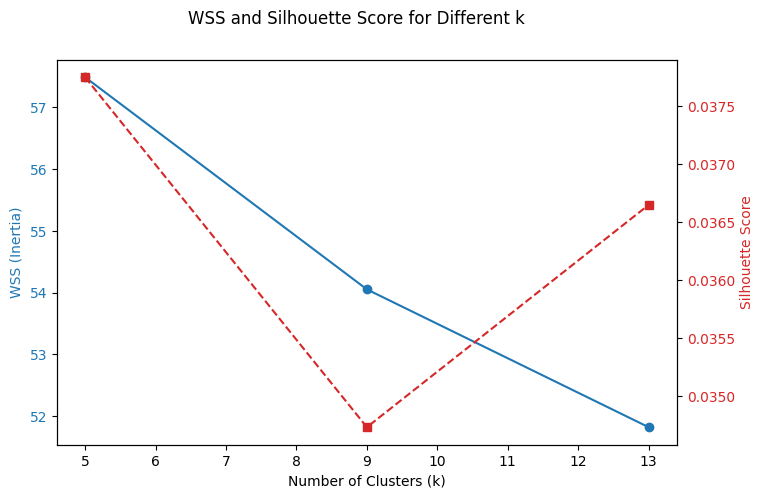

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming df['vectors'] contains sentence embeddings
X = np.vstack(df['vector'].values)

# Define cluster sizes to evaluate
cluster_sizes = [5, 9, 13]

# Store WSS and Silhouette Scores
wss = []
silhouette_scores = []

for k in cluster_sizes:
    kmeans = KMeans(n_clusters=k, random_state=24442, n_init=10)
    labels = kmeans.fit_predict(X)

    # Compute WSS (Inertia)
    wss.append(kmeans.inertia_)

    # Compute Silhouette Score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

    print(f'k={k} | WSS: {kmeans.inertia_:.4f} | Silhouette Score: {silhouette_avg:.4f}')

# Plot WSS and Silhouette Score
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WSS (Inertia)', color='tab:blue')
ax1.plot(cluster_sizes, wss, marker='o', linestyle='-', color='tab:blue', label='WSS')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(cluster_sizes, silhouette_scores, marker='s', linestyle='--', color='tab:red', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle('WSS and Silhouette Score for Different k')
plt.show()


# Training my own models


In [8]:
from gensim.models import Word2Vec
sentences = df['tokens']
# Train CBOW model
cbow_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Train Skip-gram model
skipgram_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=1)

## Training Word2Vec

In [9]:

# Function to get document embeddings (average of word embeddings)
def get_doc_embedding(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Getting an array of document embeddings (be averaging the word)
doc_vectors = np.array([get_doc_embedding(words, cbow_model) for words in sentences])

df['vector'] = list(doc_vectors)


k=5 | WSS: 0.1889 | Silhouette Score: 0.0140
k=9 | WSS: 0.1833 | Silhouette Score: 0.0130
k=13 | WSS: 0.1787 | Silhouette Score: 0.0139


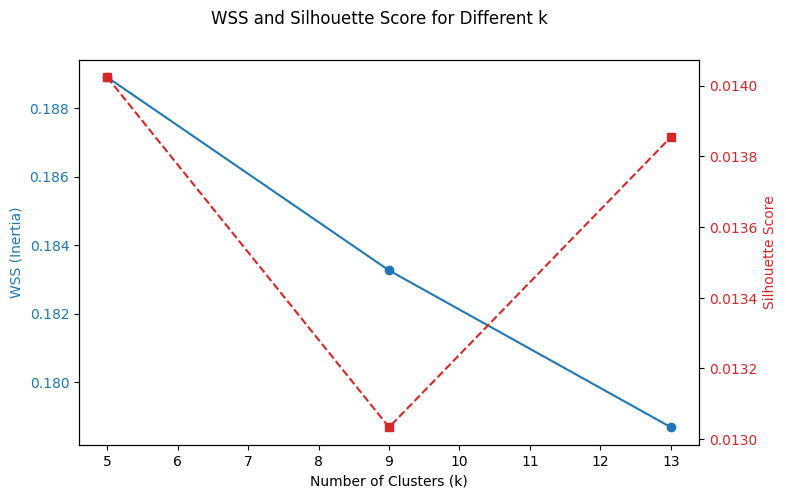

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_and_evaluate(df, cluster_sizes=[5, 9, 13], random_state=24442):
    X = np.vstack(df['vector'].values)

    wss = []
    silhouette_scores = []

    for k in cluster_sizes:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)

        wss.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X, labels)
        silhouette_scores.append(silhouette_avg)

        print(f'k={k} | WSS: {kmeans.inertia_:.4f} | Silhouette Score: {silhouette_avg:.4f}')

    # Plot WSS and Silhouette Score
    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('WSS (Inertia)', color='tab:blue')
    ax1.plot(cluster_sizes, wss, marker='o', linestyle='-', color='tab:blue', label='WSS')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='tab:red')
    ax2.plot(cluster_sizes, silhouette_scores, marker='s', linestyle='--', color='tab:red', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.suptitle('WSS and Silhouette Score for Different k')
    plt.show()

    return kmeans.labels_

df['cluster'] = cluster_and_evaluate(df)


In [11]:
df

,title,tokens,vector,cluster
0,ECC endorses purchase of $582mn capital shares...,"[ecc, endorses, purchase, mn, capital, shares,...","[0.0032670654, -0.0006865518, -0.0013878802, 0...",5
1,Netanyahu’s statement to establish Palestinian...,"[netanyahu, statement, establish, palestinian,...","[-0.0018275362, 0.0013291017, -0.0004009498, -...",4
2,"India, US agree to resolve trade and tariff ro...","[india, us, agree, resolve, trade, tariff, row...","[-0.00028940284, 0.00033763045, -0.0018390116,...",2
3,Aurangzeb discusses Pakistan’s structural refo...,"[aurangzeb, discusses, pakistan, structural, r...","[-0.0010896206, 0.0007711802, 0.004992255, 0.0...",9
4,"HBL, S&P Global launch Pakistan’s first manufa...","[hbl, p, global, launch, pakistan, first, manu...","[0.00058653613, 0.0003386506, -0.0020225907, 9...",9
...,...,...,...,...
448,SBP grants FPT clearance to Zia Ijaz as Askari...,"[sbp, grants, fpt, clearance, zia, ijaz, askar...","[0.0025082561, -0.0032760655, 0.00027834094, 0...",7
449,India’s Modi brings a tariff ‘gift’ to Trump t...,"[india, modi, brings, tariff, gift, trump, talks]","[-0.00084208685, -0.0006314997, -0.0012894071,...",11
450,Oil prices decline on optimism over potential ...,"[oil, prices, decline, optimism, potential, ru...","[-0.0008124849, -0.0010768638, -0.00018153386,...",3
451,Google partners with Poland to expand AI adopt...,"[google, partners, poland, expand, ai, adoptio...","[0.003230177, -0.00018593256, -0.0035100966, 0...",5


## Training Doc to Vec (DM and DBoW)

In [5]:
df = get_tokenized_df()

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming your DataFrame has columns 'title' and 'tokens'
# where 'tokens' contains lists of tokenized words for each document

# 1. Prepare the TaggedDocument objects
tagged_data = [TaggedDocument(words=tokens, tags=[title])
               for title, tokens in zip(df['title'], df['tokens'])]

# 2. Train the Doc2Vec model
# Choose parameters based on your data size and characteristics
vector_size = 200
window = 6
min_count = 2  # Ignore words with frequency below this
epochs = 40    # More epochs can improve quality

# Doc2Vec parameters:
# dm=1: Use PV-DM (distributed memory) - usually better quality
# dm=0: Use PV-DBOW (distributed bag of words) - usually faster
model = Doc2Vec(tagged_data, vector_size=vector_size, window=window,
                min_count=min_count, workers=4, epochs=epochs, dm=1)

# 3. Infer vectors for all documents
document_vectors = np.array([model.infer_vector(doc.words) for doc in tagged_data])

# 4. Clustering with K-means
n_clusters = 5  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=24442, n_init=10)
clusters = kmeans.fit_predict(document_vectors)

# 5. Evaluate clustering
silhouette_avg = silhouette_score(document_vectors, clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# 6. Add clusters back to original dataframe
df['cluster'] = clusters

wss = kmeans.inertia_
print(f"WSS Score: {wss:.4f}")

Silhouette Score: 0.5158
WSS Score: 7.5418


## Using Grid Search on all params

In [8]:
df = get_tokenized_df()

In [9]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm  # for progress bar

def run_embedding_grid_search(df):
    """
    Run grid search for document embedding methods and clustering parameters.

    Args:
        df: DataFrame with 'title' and 'tokens' columns where tokens is a list of strings

    Returns:
        DataFrame with results for each parameter combination
    """
    # Define hyperparameter grid
    param_grid = {
        "vector_size": [100, 200, 300],
        "window": [5, 8, 10],
        "epochs": [20, 40],
        "model_type": ["word2vec_cbow", "word2vec_skipgram", "doc2vec_dm", "doc2vec_dbow"],
        "cluster_size": [5, 9, 13]
    }

    # Prepare results list
    results = []

    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        param_grid["vector_size"],
        param_grid["window"],
        param_grid["epochs"],
        param_grid["model_type"],
        param_grid["cluster_size"]
    ))

    # Train embeddings and evaluate clustering
    for vector_size, window, epochs, model_type, k in tqdm(param_combinations):
        print(f"Training {model_type} | vec_size={vector_size} | window={window} | epochs={epochs} | k={k}")
        sg, dm = None, None

        # Train Word2Vec
        if model_type in ["word2vec_cbow", "word2vec_skipgram"]:
            sg = 1 if model_type == "word2vec_skipgram" else 0
            model = Word2Vec(df["tokens"], vector_size=vector_size, window=window,
                            min_count=1, sg=sg, epochs=epochs, workers=4)

            # Get document embeddings by averaging word vectors
            document_vectors = []
            for tokens in df["tokens"]:
                # Get vectors for words that exist in the vocabulary
                word_vectors = [model.wv[word] for word in tokens if word in model.wv]
                # If no words in vocabulary, use zero vector
                if len(word_vectors) == 0:
                    document_vectors.append(np.zeros(vector_size))
                else:
                    # Take mean of word vectors
                    doc_vector = np.mean(word_vectors, axis=0)
                    document_vectors.append(doc_vector)

            X = np.array(document_vectors)

        # Train Doc2Vec
        else:
            dm = 1 if model_type == "doc2vec_dm" else 0
            # Create TaggedDocument objects
            tagged_data = [TaggedDocument(words=tokens, tags=[str(i)])
                           for i, tokens in enumerate(df["tokens"])]

            model = Doc2Vec(tagged_data, vector_size=vector_size, window=window,
                           min_count=1, dm=dm, epochs=epochs, workers=4)

            # Get document vectors directly from the model
            document_vectors = []
            for i in range(len(df)):
                document_vectors.append(model.dv[str(i)])

            X = np.array(document_vectors)

        # Normalize vectors (optional but can improve clustering)
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        # Avoid division by zero
        norms[norms == 0] = 1
        X = X / norms

        # Apply K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Compute WSS and Silhouette Score
        wss = kmeans.inertia_
        silhouette = silhouette_score(X, labels)

        # Store results
        results.append({
            "Vectorizer Type": model_type,
            "vector_size": vector_size,
            "window": window,
            "Epochs Count": epochs,
            "CBoW/Skipgram OR DM/DBoW": "Skip-gram" if sg == 1 else
                                       "CBOW" if sg == 0 else
                                       "DM" if dm == 1 else "DBoW",
            "Silhouette Score": silhouette,
            "WSS Score": wss,
            "Cluster Size": k
        })
        print(results[-1])

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def visualize_results(results_df):
    """Generate visualizations from the grid search results"""

    # Aggregate by model type and cluster size
    model_cluster_df = results_df.groupby(['Vectorizer Type', 'Cluster Size'])['Silhouette Score'].mean().reset_index()

    # Plot silhouette scores by model type and cluster size
    plt.figure(figsize=(12, 6))
    for model in results_df['Vectorizer Type'].unique():
        model_data = model_cluster_df[model_cluster_df['Vectorizer Type'] == model]
        plt.plot(model_data['Cluster Size'], model_data['Silhouette Score'], 'o-', label=model)

    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score by Model Type and Cluster Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot the top 10 configurations
    top_configs = results_df.sort_values('Silhouette Score', ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    plt.bar(
        [f"{row['Vectorizer Type']}\nvs={row['vector_size']}, w={row['window']}, k={row['Cluster Size']}"
         for _, row in top_configs.iterrows()],
        top_configs['Silhouette Score']
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Configurations by Silhouette Score')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return top_configs


  0%|          | 0/216 [00:00<?, ?it/s]

Training word2vec_cbow | vec_size=100 | window=5 | epochs=20 | k=5


  0%|          | 1/216 [00:00<01:02,  3.45it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.00825735, 'WSS Score': 293.06640625, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=5 | epochs=20 | k=9


  1%|          | 2/216 [00:00<01:09,  3.09it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0035770165, 'WSS Score': 283.8517761230469, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=5 | epochs=20 | k=13


  1%|▏         | 3/216 [00:01<01:14,  2.84it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0013161096, 'WSS Score': 276.8826904296875, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=20 | k=5


  2%|▏         | 4/216 [00:01<01:31,  2.33it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.033407785, 'WSS Score': 6.611342430114746, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=20 | k=9


  2%|▏         | 5/216 [00:02<01:41,  2.07it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.043901425, 'WSS Score': 6.357903003692627, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=20 | k=13


  3%|▎         | 6/216 [00:02<01:48,  1.93it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.0069259997, 'WSS Score': 5.969820499420166, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=20 | k=5


  3%|▎         | 7/216 [00:03<01:52,  1.86it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.010380543, 'WSS Score': 426.760498046875, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=20 | k=9


  4%|▎         | 8/216 [00:03<01:55,  1.80it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.009223464, 'WSS Score': 417.3336181640625, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=20 | k=13


  4%|▍         | 9/216 [00:04<01:58,  1.75it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.008108972, 'WSS Score': 409.4656066894531, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=20 | k=5


  5%|▍         | 10/216 [00:04<01:48,  1.89it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.01078461, 'WSS Score': 416.05035400390625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=20 | k=9


  5%|▌         | 11/216 [00:05<01:42,  2.01it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.009226336, 'WSS Score': 407.14031982421875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=20 | k=13


  6%|▌         | 12/216 [00:05<01:38,  2.08it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.008561734, 'WSS Score': 399.0057373046875, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=100 | window=5 | epochs=40 | k=5


  6%|▌         | 13/216 [00:06<01:37,  2.08it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.024779987, 'WSS Score': 10.592997550964355, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=5 | epochs=40 | k=9


  6%|▋         | 14/216 [00:07<01:50,  1.82it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.008959111, 'WSS Score': 9.950698852539062, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=5 | epochs=40 | k=13


  7%|▋         | 15/216 [00:07<02:00,  1.67it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.034531776, 'WSS Score': 9.481847763061523, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=40 | k=5


  7%|▋         | 16/216 [00:09<02:46,  1.20it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.23180039, 'WSS Score': 4.6038665771484375, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=40 | k=9


  8%|▊         | 17/216 [00:10<02:53,  1.15it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.20913053, 'WSS Score': 3.532396078109741, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=5 | epochs=40 | k=13


  8%|▊         | 18/216 [00:11<02:59,  1.10it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.19829221, 'WSS Score': 2.9459598064422607, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=40 | k=5


  9%|▉         | 19/216 [00:12<03:05,  1.06it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0073670647, 'WSS Score': 139.65150451660156, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=40 | k=9


  9%|▉         | 20/216 [00:13<03:09,  1.03it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.0065543144, 'WSS Score': 136.7859649658203, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=5 | epochs=40 | k=13


 10%|▉         | 21/216 [00:14<03:13,  1.01it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.025134504, 'WSS Score': 133.8250732421875, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=40 | k=5


 10%|█         | 22/216 [00:14<02:55,  1.10it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0023350166, 'WSS Score': 142.34860229492188, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=40 | k=9


 11%|█         | 23/216 [00:15<02:43,  1.18it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0037000622, 'WSS Score': 138.9871368408203, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=5 | epochs=40 | k=13


 11%|█         | 24/216 [00:16<02:35,  1.23it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0032364323, 'WSS Score': 136.20928955078125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=20 | k=5


 12%|█▏        | 25/216 [00:16<02:07,  1.49it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.041537974, 'WSS Score': 239.849609375, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=20 | k=9


 12%|█▏        | 26/216 [00:16<01:48,  1.75it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.01692005, 'WSS Score': 232.10008239746094, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=20 | k=13


 12%|█▎        | 27/216 [00:17<01:37,  1.94it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.013565029, 'WSS Score': 226.879150390625, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=20 | k=5


 13%|█▎        | 28/216 [00:17<01:43,  1.82it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.036421146, 'WSS Score': 1.3446159362792969, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=20 | k=9


 13%|█▎        | 29/216 [00:18<01:49,  1.71it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.050070588, 'WSS Score': 1.2396739721298218, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=20 | k=13


 14%|█▍        | 30/216 [00:19<02:07,  1.46it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.045488723, 'WSS Score': 1.160042405128479, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=20 | k=5


 14%|█▍        | 31/216 [00:20<02:17,  1.35it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.011014433, 'WSS Score': 425.0747375488281, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=20 | k=9


 15%|█▍        | 32/216 [00:21<02:27,  1.25it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.010156988, 'WSS Score': 415.0207214355469, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=20 | k=13


 15%|█▌        | 33/216 [00:22<02:16,  1.34it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0071541416, 'WSS Score': 408.525390625, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=20 | k=5


 16%|█▌        | 34/216 [00:22<01:57,  1.55it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.01078461, 'WSS Score': 416.05035400390625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=20 | k=9


 16%|█▌        | 35/216 [00:22<01:46,  1.71it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.009226336, 'WSS Score': 407.14031982421875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=20 | k=13


 17%|█▋        | 36/216 [00:23<01:38,  1.82it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.008561734, 'WSS Score': 399.0057373046875, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=40 | k=5


 17%|█▋        | 37/216 [00:23<01:35,  1.87it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.028481886, 'WSS Score': 3.6108312606811523, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=40 | k=9


 18%|█▊        | 38/216 [00:24<01:34,  1.89it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.034322098, 'WSS Score': 3.3805994987487793, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=8 | epochs=40 | k=13


 18%|█▊        | 39/216 [00:24<01:35,  1.86it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.042003796, 'WSS Score': 3.1468703746795654, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=40 | k=5


 19%|█▊        | 40/216 [00:25<02:03,  1.42it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.2221049, 'WSS Score': 20.508657455444336, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=40 | k=9


 19%|█▉        | 41/216 [00:27<02:24,  1.21it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.24502651, 'WSS Score': 15.945036888122559, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=8 | epochs=40 | k=13


 19%|█▉        | 42/216 [00:28<02:39,  1.09it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.24130632, 'WSS Score': 13.149911880493164, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=40 | k=5


 20%|█▉        | 43/216 [00:29<02:43,  1.06it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.006448529, 'WSS Score': 84.65428924560547, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=40 | k=9


 20%|██        | 44/216 [00:30<02:46,  1.03it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.00018318197, 'WSS Score': 82.79641723632812, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=8 | epochs=40 | k=13


 21%|██        | 45/216 [00:31<02:49,  1.01it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.015777694, 'WSS Score': 81.1180648803711, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=40 | k=5


 21%|██▏       | 46/216 [00:32<02:51,  1.01s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0023350166, 'WSS Score': 142.34860229492188, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=40 | k=9


 22%|██▏       | 47/216 [00:33<02:52,  1.02s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0037000622, 'WSS Score': 138.9871368408203, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=8 | epochs=40 | k=13


 22%|██▏       | 48/216 [00:34<02:42,  1.04it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0032364323, 'WSS Score': 136.20928955078125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=20 | k=5


 23%|██▎       | 49/216 [00:34<02:09,  1.29it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.021817552, 'WSS Score': 220.60787963867188, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=20 | k=9


 23%|██▎       | 50/216 [00:34<01:47,  1.54it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.037390478, 'WSS Score': 213.996826171875, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=20 | k=13


 24%|██▎       | 51/216 [00:35<01:33,  1.76it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.033619303, 'WSS Score': 208.6536407470703, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=20 | k=5


 24%|██▍       | 52/216 [00:35<01:36,  1.69it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.05724444, 'WSS Score': 0.994288980960846, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=20 | k=9


 25%|██▍       | 53/216 [00:36<01:40,  1.62it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.06596056, 'WSS Score': 0.9119880199432373, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=20 | k=13


 25%|██▌       | 54/216 [00:37<01:44,  1.55it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.07004751, 'WSS Score': 0.8508656024932861, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=20 | k=5


 25%|██▌       | 55/216 [00:37<01:40,  1.61it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.010155506, 'WSS Score': 424.94879150390625, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=20 | k=9


 26%|██▌       | 56/216 [00:38<01:39,  1.61it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.00958697, 'WSS Score': 414.9992370605469, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=20 | k=13


 26%|██▋       | 57/216 [00:39<01:39,  1.60it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.008482491, 'WSS Score': 406.7185974121094, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=20 | k=5


 27%|██▋       | 58/216 [00:39<01:28,  1.79it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.01078461, 'WSS Score': 416.05035400390625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=20 | k=9


 27%|██▋       | 59/216 [00:40<01:21,  1.92it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.009226336, 'WSS Score': 407.14031982421875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=20 | k=13


 28%|██▊       | 60/216 [00:40<01:18,  1.98it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.008561734, 'WSS Score': 399.0057373046875, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=40 | k=5


 28%|██▊       | 61/216 [00:40<01:18,  1.99it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.068020366, 'WSS Score': 2.5782268047332764, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=40 | k=9


 29%|██▊       | 62/216 [00:41<01:20,  1.92it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.06540918, 'WSS Score': 2.3688271045684814, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=100 | window=10 | epochs=40 | k=13


 29%|██▉       | 63/216 [00:42<01:20,  1.90it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.020217212, 'WSS Score': 2.2264788150787354, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=40 | k=5


 30%|██▉       | 64/216 [00:43<01:48,  1.40it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.2158202, 'WSS Score': 30.90204429626465, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=40 | k=9


 30%|███       | 65/216 [00:44<02:22,  1.06it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.20948224, 'WSS Score': 24.610721588134766, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=100 | window=10 | epochs=40 | k=13


 31%|███       | 66/216 [00:46<02:51,  1.14s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.2236208, 'WSS Score': 20.4022274017334, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=40 | k=5


 31%|███       | 67/216 [00:47<02:44,  1.10s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.0026038124, 'WSS Score': 67.24244689941406, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=40 | k=9


 31%|███▏      | 68/216 [00:48<02:41,  1.09s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.008467155, 'WSS Score': 65.62031555175781, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=100 | window=10 | epochs=40 | k=13


 32%|███▏      | 69/216 [00:49<02:38,  1.08s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.0372472, 'WSS Score': 64.19512176513672, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=40 | k=5


 32%|███▏      | 70/216 [00:50<02:19,  1.05it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0023350166, 'WSS Score': 142.34860229492188, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=40 | k=9


 33%|███▎      | 71/216 [00:50<02:06,  1.14it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0037000622, 'WSS Score': 138.9871368408203, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=100 | window=10 | epochs=40 | k=13


 33%|███▎      | 72/216 [00:51<01:59,  1.21it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 100, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.0032364323, 'WSS Score': 136.20928955078125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=20 | k=5


 34%|███▍      | 73/216 [00:51<01:39,  1.44it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.024839785, 'WSS Score': 303.2674560546875, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=20 | k=9


 34%|███▍      | 74/216 [00:52<01:26,  1.65it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0093987165, 'WSS Score': 297.49566650390625, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=20 | k=13


 35%|███▍      | 75/216 [00:52<01:18,  1.79it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.008102081, 'WSS Score': 290.12890625, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=20 | k=5


 35%|███▌      | 76/216 [00:53<01:22,  1.69it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.043927427, 'WSS Score': 6.419071197509766, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=20 | k=9


 36%|███▌      | 77/216 [00:54<01:26,  1.60it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': -0.0015436751, 'WSS Score': 6.036556243896484, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=20 | k=13


 36%|███▌      | 78/216 [00:54<01:30,  1.52it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': -0.009629432, 'WSS Score': 5.7218732833862305, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=20 | k=5


 37%|███▋      | 79/216 [00:55<01:28,  1.55it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0049690693, 'WSS Score': 433.4523010253906, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=20 | k=9


 37%|███▋      | 80/216 [00:56<01:29,  1.52it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0034882918, 'WSS Score': 426.517578125, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=20 | k=13


 38%|███▊      | 81/216 [00:57<01:49,  1.23it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0025128745, 'WSS Score': 420.76800537109375, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=20 | k=5


 38%|███▊      | 82/216 [00:58<01:44,  1.28it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0055454033, 'WSS Score': 420.03948974609375, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=20 | k=9


 38%|███▊      | 83/216 [00:58<01:38,  1.35it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0036107495, 'WSS Score': 413.62255859375, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=20 | k=13


 39%|███▉      | 84/216 [00:59<01:28,  1.49it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0012092184, 'WSS Score': 408.2716064453125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=40 | k=5


 39%|███▉      | 85/216 [00:59<01:23,  1.57it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.12919453, 'WSS Score': 11.352744102478027, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=40 | k=9


 40%|███▉      | 86/216 [01:00<01:21,  1.59it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0078100706, 'WSS Score': 10.688933372497559, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=5 | epochs=40 | k=13


 40%|████      | 87/216 [01:01<01:22,  1.57it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.0036574802, 'WSS Score': 10.23772144317627, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=40 | k=5


 41%|████      | 88/216 [01:02<01:41,  1.26it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.21825919, 'WSS Score': 2.1285953521728516, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=40 | k=9


 41%|████      | 89/216 [01:03<01:54,  1.11it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.18146744, 'WSS Score': 1.6571950912475586, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=5 | epochs=40 | k=13


 42%|████▏     | 90/216 [01:04<02:04,  1.01it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.19752946, 'WSS Score': 1.4075651168823242, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=40 | k=5


 42%|████▏     | 91/216 [01:05<02:07,  1.02s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.007956158, 'WSS Score': 145.95042419433594, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=40 | k=9


 43%|████▎     | 92/216 [01:06<02:09,  1.05s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.014730327, 'WSS Score': 143.48985290527344, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=5 | epochs=40 | k=13


 43%|████▎     | 93/216 [01:07<02:12,  1.08s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.027298585, 'WSS Score': 141.54159545898438, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=40 | k=5


 44%|████▎     | 94/216 [01:08<02:06,  1.04s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.002173842, 'WSS Score': 130.8131866455078, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=40 | k=9


 44%|████▍     | 95/216 [01:10<02:12,  1.10s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.01485165, 'WSS Score': 128.5835723876953, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=5 | epochs=40 | k=13


 44%|████▍     | 96/216 [01:11<02:13,  1.11s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.03464246, 'WSS Score': 126.412109375, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=20 | k=5


 45%|████▍     | 97/216 [01:11<01:46,  1.11it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.017044341, 'WSS Score': 247.04782104492188, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=20 | k=9


 45%|████▌     | 98/216 [01:12<01:28,  1.33it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.0008226325, 'WSS Score': 241.54286193847656, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=20 | k=13


 46%|████▌     | 99/216 [01:12<01:17,  1.50it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0033720837, 'WSS Score': 234.92420959472656, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=20 | k=5


 46%|████▋     | 100/216 [01:13<01:20,  1.44it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.01394076, 'WSS Score': 0.916819155216217, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=20 | k=9


 47%|████▋     | 101/216 [01:14<01:23,  1.38it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.013502121, 'WSS Score': 0.8646727204322815, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=20 | k=13


 47%|████▋     | 102/216 [01:14<01:25,  1.33it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.024182046, 'WSS Score': 0.805754542350769, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=20 | k=5


 48%|████▊     | 103/216 [01:15<01:21,  1.39it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0049084816, 'WSS Score': 431.8963317871094, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=20 | k=9


 48%|████▊     | 104/216 [01:16<01:18,  1.43it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.003884145, 'WSS Score': 425.0423889160156, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=20 | k=13


 49%|████▊     | 105/216 [01:16<01:17,  1.44it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0022461107, 'WSS Score': 419.5564880371094, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=20 | k=5


 49%|████▉     | 106/216 [01:17<01:08,  1.61it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0055454033, 'WSS Score': 420.03948974609375, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=20 | k=9


 50%|████▉     | 107/216 [01:17<01:02,  1.73it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0036107495, 'WSS Score': 413.62255859375, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=20 | k=13


 50%|█████     | 108/216 [01:18<00:59,  1.81it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0012092184, 'WSS Score': 408.2716064453125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=40 | k=5


 50%|█████     | 109/216 [01:18<01:00,  1.77it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.07319297, 'WSS Score': 3.6848840713500977, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=40 | k=9


 51%|█████     | 110/216 [01:19<01:02,  1.70it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0076316143, 'WSS Score': 3.3892927169799805, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=8 | epochs=40 | k=13


 51%|█████▏    | 111/216 [01:20<01:04,  1.64it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.021033665, 'WSS Score': 3.1901042461395264, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=40 | k=5


 52%|█████▏    | 112/216 [01:21<01:35,  1.09it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.30095047, 'WSS Score': 11.528916358947754, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=40 | k=9


 52%|█████▏    | 113/216 [01:23<02:03,  1.20s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.22667179, 'WSS Score': 8.737997055053711, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=8 | epochs=40 | k=13


 53%|█████▎    | 114/216 [01:25<02:08,  1.26s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.25376537, 'WSS Score': 7.0591206550598145, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=40 | k=5


 53%|█████▎    | 115/216 [01:26<02:02,  1.22s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.04495125, 'WSS Score': 86.76056671142578, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=40 | k=9


 54%|█████▎    | 116/216 [01:27<01:59,  1.20s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.05762679, 'WSS Score': 85.044189453125, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=8 | epochs=40 | k=13


 54%|█████▍    | 117/216 [01:28<01:57,  1.19s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.02603389, 'WSS Score': 83.31494140625, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=40 | k=5


 55%|█████▍    | 118/216 [01:29<01:43,  1.06s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.002173842, 'WSS Score': 130.8131866455078, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=40 | k=9


 55%|█████▌    | 119/216 [01:29<01:34,  1.03it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.01485165, 'WSS Score': 128.5835723876953, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=8 | epochs=40 | k=13


 56%|█████▌    | 120/216 [01:30<01:28,  1.08it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.03464246, 'WSS Score': 126.412109375, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=20 | k=5


 56%|█████▌    | 121/216 [01:31<01:12,  1.31it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.032263394, 'WSS Score': 229.1304931640625, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=20 | k=9


 56%|█████▋    | 122/216 [01:31<01:01,  1.52it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.007137858, 'WSS Score': 222.85714721679688, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=20 | k=13


 57%|█████▋    | 123/216 [01:32<00:55,  1.67it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.01378988, 'WSS Score': 217.90325927734375, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=20 | k=5


 57%|█████▋    | 124/216 [01:32<01:00,  1.52it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.041268837, 'WSS Score': 0.607840895652771, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=20 | k=9


 58%|█████▊    | 125/216 [01:33<01:11,  1.27it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.042608943, 'WSS Score': 0.5689213275909424, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=20 | k=13


 58%|█████▊    | 126/216 [01:35<01:24,  1.06it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.023765573, 'WSS Score': 0.534018337726593, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=20 | k=5


 59%|█████▉    | 127/216 [01:36<01:19,  1.12it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0046976213, 'WSS Score': 431.54949951171875, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=20 | k=9


 59%|█████▉    | 128/216 [01:36<01:12,  1.21it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0036171253, 'WSS Score': 424.6391296386719, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=20 | k=13


 60%|█████▉    | 129/216 [01:37<01:08,  1.27it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.00156188, 'WSS Score': 419.2996520996094, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=20 | k=5


 60%|██████    | 130/216 [01:37<00:58,  1.46it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0055454033, 'WSS Score': 420.03948974609375, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=20 | k=9


 61%|██████    | 131/216 [01:38<00:53,  1.58it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0036107495, 'WSS Score': 413.62255859375, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=20 | k=13


 61%|██████    | 132/216 [01:38<00:49,  1.68it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0012092184, 'WSS Score': 408.2716064453125, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=40 | k=5


 62%|██████▏   | 133/216 [01:39<00:48,  1.70it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.18288645, 'WSS Score': 2.50882887840271, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=40 | k=9


 62%|██████▏   | 134/216 [01:40<00:48,  1.68it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.06265134, 'WSS Score': 2.3446879386901855, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=200 | window=10 | epochs=40 | k=13


 62%|██████▎   | 135/216 [01:40<00:49,  1.63it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.00041159574, 'WSS Score': 2.2358644008636475, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=40 | k=5


 63%|██████▎   | 136/216 [01:42<01:08,  1.17it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.22471726, 'WSS Score': 18.829936981201172, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=40 | k=9


 63%|██████▎   | 137/216 [01:43<01:21,  1.03s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.22837645, 'WSS Score': 14.609210014343262, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=200 | window=10 | epochs=40 | k=13


 64%|██████▍   | 138/216 [01:45<01:30,  1.16s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.2406842, 'WSS Score': 11.777652740478516, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=40 | k=5


 64%|██████▍   | 139/216 [01:46<01:36,  1.26s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.008993401, 'WSS Score': 69.4661865234375, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=40 | k=9


 65%|██████▍   | 140/216 [01:48<01:59,  1.58s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.008065948, 'WSS Score': 67.82940673828125, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=200 | window=10 | epochs=40 | k=13


 65%|██████▌   | 141/216 [01:50<01:58,  1.58s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.011268654, 'WSS Score': 66.71449279785156, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=40 | k=5


 66%|██████▌   | 142/216 [01:51<01:38,  1.33s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.002173842, 'WSS Score': 130.8131866455078, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=40 | k=9


 66%|██████▌   | 143/216 [01:51<01:25,  1.17s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.01485165, 'WSS Score': 128.5835723876953, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=200 | window=10 | epochs=40 | k=13


 67%|██████▋   | 144/216 [01:52<01:16,  1.06s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 200, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.03464246, 'WSS Score': 126.412109375, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=20 | k=5


 67%|██████▋   | 145/216 [01:53<01:02,  1.14it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.027439706, 'WSS Score': 297.6341247558594, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=20 | k=9


 68%|██████▊   | 146/216 [01:53<00:52,  1.33it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.018837081, 'WSS Score': 289.2684631347656, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=20 | k=13


 68%|██████▊   | 147/216 [01:54<00:46,  1.47it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.008983654, 'WSS Score': 283.8287353515625, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=20 | k=5


 69%|██████▊   | 148/216 [01:54<00:48,  1.42it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.07438506, 'WSS Score': 5.928328990936279, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=20 | k=9


 69%|██████▉   | 149/216 [01:55<00:49,  1.36it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.021957291, 'WSS Score': 5.769075393676758, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=20 | k=13


 69%|██████▉   | 150/216 [01:56<00:50,  1.30it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.0024014704, 'WSS Score': 5.388380527496338, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=20 | k=5


 70%|██████▉   | 151/216 [01:57<00:48,  1.33it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0035284865, 'WSS Score': 434.7449645996094, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=20 | k=9


 70%|███████   | 152/216 [01:58<00:47,  1.34it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0016532148, 'WSS Score': 429.3981018066406, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=20 | k=13


 71%|███████   | 153/216 [01:58<00:46,  1.35it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0002567509, 'WSS Score': 424.36309814453125, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=20 | k=5


 71%|███████▏  | 154/216 [01:59<00:46,  1.33it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.003078464, 'WSS Score': 424.2949523925781, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=20 | k=9


 72%|███████▏  | 155/216 [02:00<00:48,  1.27it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0010209191, 'WSS Score': 419.22869873046875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=20 | k=13


 72%|███████▏  | 156/216 [02:01<00:50,  1.19it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -6.425923e-05, 'WSS Score': 413.9142761230469, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=40 | k=5


 73%|███████▎  | 157/216 [02:02<00:46,  1.28it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.110029966, 'WSS Score': 10.37117862701416, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=40 | k=9


 73%|███████▎  | 158/216 [02:02<00:43,  1.32it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.005888395, 'WSS Score': 9.864471435546875, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=5 | epochs=40 | k=13


 74%|███████▎  | 159/216 [02:03<00:42,  1.34it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.06842262, 'WSS Score': 9.377386093139648, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=40 | k=5


 74%|███████▍  | 160/216 [02:04<00:51,  1.08it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.4072118, 'WSS Score': 1.4092007875442505, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=40 | k=9


 75%|███████▍  | 161/216 [02:06<00:58,  1.06s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.18275408, 'WSS Score': 1.1007193326950073, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=5 | epochs=40 | k=13


 75%|███████▌  | 162/216 [02:07<01:02,  1.16s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.19406667, 'WSS Score': 0.9112012386322021, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=40 | k=5


 75%|███████▌  | 163/216 [02:08<01:03,  1.20s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.00908679, 'WSS Score': 137.30715942382812, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=40 | k=9


 76%|███████▌  | 164/216 [02:10<01:04,  1.23s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.02923032, 'WSS Score': 135.0906524658203, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=5 | epochs=40 | k=13


 76%|███████▋  | 165/216 [02:11<01:05,  1.28s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.0019114855, 'WSS Score': 132.413330078125, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=40 | k=5


 77%|███████▋  | 166/216 [02:12<01:04,  1.29s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.022568287, 'WSS Score': 140.20904541015625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=40 | k=9


 77%|███████▋  | 167/216 [02:14<01:01,  1.26s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.016460884, 'WSS Score': 138.11219787597656, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=5 | epochs=40 | k=13


 78%|███████▊  | 168/216 [02:14<00:55,  1.15s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 5, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.006012657, 'WSS Score': 135.67864990234375, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=20 | k=5


 78%|███████▊  | 169/216 [02:15<00:44,  1.07it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.032797426, 'WSS Score': 244.009521484375, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=20 | k=9


 79%|███████▊  | 170/216 [02:15<00:36,  1.25it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0155511815, 'WSS Score': 238.06463623046875, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=20 | k=13


 79%|███████▉  | 171/216 [02:16<00:32,  1.40it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.0012070305, 'WSS Score': 233.3120880126953, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=20 | k=5


 80%|███████▉  | 172/216 [02:17<00:33,  1.30it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.07604551, 'WSS Score': 0.8116797208786011, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=20 | k=9


 80%|████████  | 173/216 [02:18<00:35,  1.22it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': -0.0099833235, 'WSS Score': 0.762829601764679, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=20 | k=13


 81%|████████  | 174/216 [02:19<00:36,  1.16it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.026192503, 'WSS Score': 0.7025983333587646, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=20 | k=5


 81%|████████  | 175/216 [02:19<00:33,  1.22it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0034070297, 'WSS Score': 433.248291015625, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=20 | k=9


 81%|████████▏ | 176/216 [02:20<00:31,  1.26it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0017686615, 'WSS Score': 427.92889404296875, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=20 | k=13


 82%|████████▏ | 177/216 [02:21<00:30,  1.27it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.00010817001, 'WSS Score': 422.86053466796875, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=20 | k=5


 82%|████████▏ | 178/216 [02:21<00:26,  1.42it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.003078464, 'WSS Score': 424.2949523925781, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=20 | k=9


 83%|████████▎ | 179/216 [02:22<00:24,  1.53it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0010209191, 'WSS Score': 419.22869873046875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=20 | k=13


 83%|████████▎ | 180/216 [02:23<00:22,  1.59it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -6.425923e-05, 'WSS Score': 413.9142761230469, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=40 | k=5


 84%|████████▍ | 181/216 [02:23<00:22,  1.55it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.17190915, 'WSS Score': 3.4671506881713867, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=40 | k=9


 84%|████████▍ | 182/216 [02:24<00:26,  1.29it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.04184623, 'WSS Score': 3.254983425140381, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=8 | epochs=40 | k=13


 85%|████████▍ | 183/216 [02:26<00:30,  1.09it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.06304403, 'WSS Score': 3.035921573638916, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=40 | k=5


 85%|████████▌ | 184/216 [02:27<00:36,  1.13s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.44561633, 'WSS Score': 8.008879661560059, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=40 | k=9


 86%|████████▌ | 185/216 [02:29<00:39,  1.28s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.21498442, 'WSS Score': 6.084505558013916, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=8 | epochs=40 | k=13


 86%|████████▌ | 186/216 [02:30<00:41,  1.39s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.24654293, 'WSS Score': 4.954076290130615, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=40 | k=5


 87%|████████▋ | 187/216 [02:32<00:39,  1.35s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.039236628, 'WSS Score': 80.79053497314453, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=40 | k=9


 87%|████████▋ | 188/216 [02:33<00:37,  1.32s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': -0.0063153207, 'WSS Score': 79.53062438964844, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=8 | epochs=40 | k=13


 88%|████████▊ | 189/216 [02:34<00:35,  1.32s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.020904735, 'WSS Score': 78.15968322753906, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=40 | k=5


 88%|████████▊ | 190/216 [02:35<00:30,  1.17s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.022568287, 'WSS Score': 140.20904541015625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=40 | k=9


 88%|████████▊ | 191/216 [02:36<00:28,  1.14s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.016460884, 'WSS Score': 138.11219787597656, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=8 | epochs=40 | k=13


 89%|████████▉ | 192/216 [02:38<00:29,  1.24s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 8, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.006012657, 'WSS Score': 135.67864990234375, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=20 | k=5


 89%|████████▉ | 193/216 [02:38<00:24,  1.07s/it]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.031567164, 'WSS Score': 222.8686981201172, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=20 | k=9


 90%|████████▉ | 194/216 [02:39<00:19,  1.12it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.050031114, 'WSS Score': 216.82025146484375, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=20 | k=13


 90%|█████████ | 195/216 [02:39<00:16,  1.28it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.030194264, 'WSS Score': 213.97219848632812, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=20 | k=5


 91%|█████████ | 196/216 [02:40<00:16,  1.21it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.04535834, 'WSS Score': 0.5016929507255554, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=20 | k=9


 91%|█████████ | 197/216 [02:41<00:16,  1.13it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.028770708, 'WSS Score': 0.46244898438453674, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=20 | k=13


 92%|█████████▏| 198/216 [02:42<00:16,  1.08it/s]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.05506936, 'WSS Score': 0.43088364601135254, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=20 | k=5


 92%|█████████▏| 199/216 [02:43<00:14,  1.17it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0034357738, 'WSS Score': 432.5270080566406, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=20 | k=9


 93%|█████████▎| 200/216 [02:44<00:13,  1.22it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.0018704889, 'WSS Score': 426.9944763183594, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=20 | k=13


 93%|█████████▎| 201/216 [02:44<00:11,  1.25it/s]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.00051450054, 'WSS Score': 421.6596374511719, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=20 | k=5


 94%|█████████▎| 202/216 [02:45<00:09,  1.41it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.003078464, 'WSS Score': 424.2949523925781, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=20 | k=9


 94%|█████████▍| 203/216 [02:45<00:08,  1.53it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.0010209191, 'WSS Score': 419.22869873046875, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=20 | k=13


 94%|█████████▍| 204/216 [02:46<00:07,  1.60it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 20, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -6.425923e-05, 'WSS Score': 413.9142761230469, 'Cluster Size': 13}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=40 | k=5


 95%|█████████▍| 205/216 [02:47<00:07,  1.57it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.12625638, 'WSS Score': 2.2635464668273926, 'Cluster Size': 5}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=40 | k=9


 95%|█████████▌| 206/216 [02:47<00:06,  1.53it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': 0.1293332, 'WSS Score': 2.136247158050537, 'Cluster Size': 9}
Training word2vec_cbow | vec_size=300 | window=10 | epochs=40 | k=13


 96%|█████████▌| 207/216 [02:48<00:06,  1.45it/s]

{'Vectorizer Type': 'word2vec_cbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'CBOW', 'Silhouette Score': -0.023313098, 'WSS Score': 2.0415139198303223, 'Cluster Size': 13}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=40 | k=5


 96%|█████████▋| 208/216 [02:51<00:09,  1.21s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.4050349, 'WSS Score': 14.293173789978027, 'Cluster Size': 5}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=40 | k=9


 97%|█████████▋| 209/216 [02:52<00:09,  1.36s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.22746994, 'WSS Score': 10.943933486938477, 'Cluster Size': 9}
Training word2vec_skipgram | vec_size=300 | window=10 | epochs=40 | k=13


 97%|█████████▋| 210/216 [02:54<00:08,  1.48s/it]

{'Vectorizer Type': 'word2vec_skipgram', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'Skip-gram', 'Silhouette Score': 0.30684346, 'WSS Score': 8.679572105407715, 'Cluster Size': 13}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=40 | k=5


 98%|█████████▊| 211/216 [02:55<00:07,  1.40s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.04635814, 'WSS Score': 63.403621673583984, 'Cluster Size': 5}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=40 | k=9


 98%|█████████▊| 212/216 [02:57<00:05,  1.36s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.016304173, 'WSS Score': 62.13562774658203, 'Cluster Size': 9}
Training doc2vec_dm | vec_size=300 | window=10 | epochs=40 | k=13


 99%|█████████▊| 213/216 [02:58<00:04,  1.35s/it]

{'Vectorizer Type': 'doc2vec_dm', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DM', 'Silhouette Score': 0.013990805, 'WSS Score': 60.64640426635742, 'Cluster Size': 13}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=40 | k=5


 99%|█████████▉| 214/216 [02:59<00:02,  1.19s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.022568287, 'WSS Score': 140.20904541015625, 'Cluster Size': 5}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=40 | k=9


100%|█████████▉| 215/216 [03:00<00:01,  1.09s/it]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': 0.016460884, 'WSS Score': 138.11219787597656, 'Cluster Size': 9}
Training doc2vec_dbow | vec_size=300 | window=10 | epochs=40 | k=13


100%|██████████| 216/216 [03:00<00:00,  1.19it/s]

{'Vectorizer Type': 'doc2vec_dbow', 'vector_size': 300, 'window': 10, 'Epochs Count': 40, 'CBoW/Skipgram OR DM/DBoW': 'DBoW', 'Silhouette Score': -0.006012657, 'WSS Score': 135.67864990234375, 'Cluster Size': 13}
       Vectorizer Type  vector_size  window  Epochs Count  \
0        word2vec_cbow          100       5            20   
1        word2vec_cbow          100       5            20   
2        word2vec_cbow          100       5            20   
3    word2vec_skipgram          100       5            20   
4    word2vec_skipgram          100       5            20   
..                 ...          ...     ...           ...   
211         doc2vec_dm          300      10            40   
212         doc2vec_dm          300      10            40   
213       doc2vec_dbow          300      10            40   
214       doc2vec_dbow          300      10            40   
215       doc2vec_dbow          300      10            40   

    CBoW/Skipgram OR DM/DBoW  Silhouette Score   WSS S

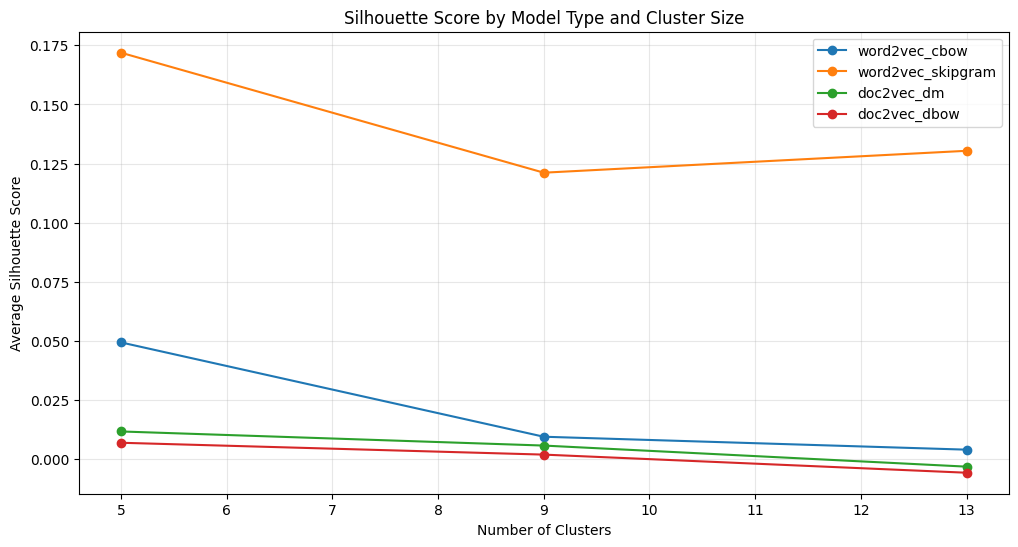

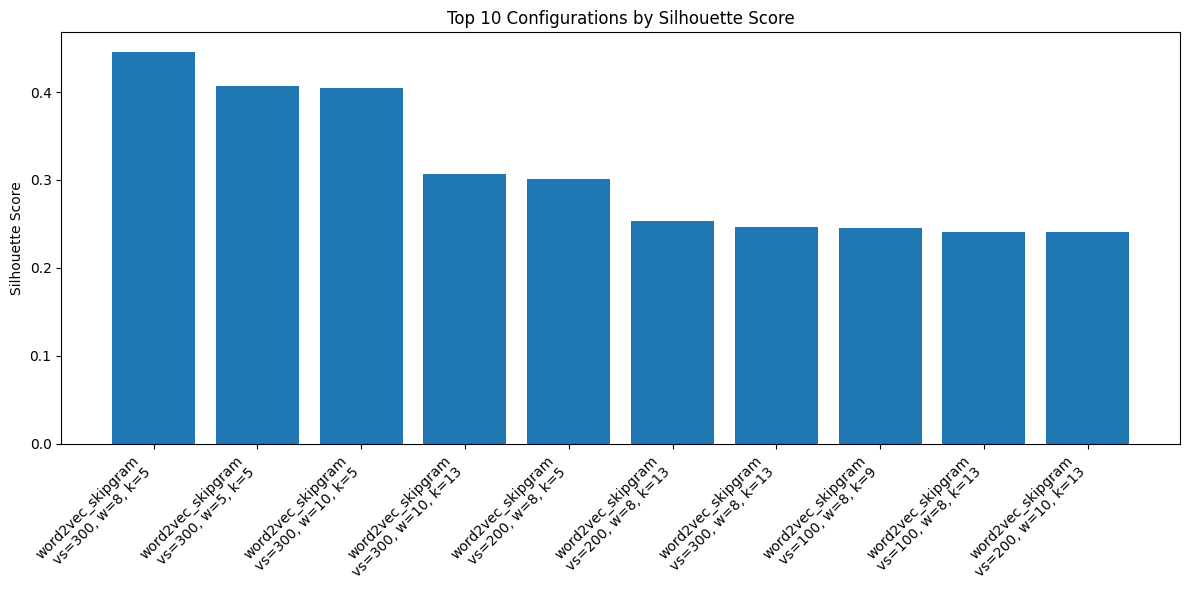

Top 10 configurations:
       Vectorizer Type  vector_size  window  Epochs Count  \
183  word2vec_skipgram          300       8            40   
159  word2vec_skipgram          300       5            40   
207  word2vec_skipgram          300      10            40   
209  word2vec_skipgram          300      10            40   
111  word2vec_skipgram          200       8            40   
113  word2vec_skipgram          200       8            40   
185  word2vec_skipgram          300       8            40   
40   word2vec_skipgram          100       8            40   
41   word2vec_skipgram          100       8            40   
137  word2vec_skipgram          200      10            40   

    CBoW/Skipgram OR DM/DBoW  Silhouette Score  WSS Score  Cluster Size  
183                Skip-gram          0.445616   8.008880             5  
159                Skip-gram          0.407212   1.409201             5  
207                Skip-gram          0.405035  14.293174             5  
209      

In [20]:
results_df = run_embedding_grid_search(df)
print(results_df)

# Visualize results
top_configs = visualize_results(results_df)
print("Top 10 configurations:")
print(top_configs)

In [ ]:
results_df